# Loess Regression
**Goal**: Small notebook to play around with settings and review results

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sklego.loess import LoessRegressor
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Create dummy dataset
Sinewave with a gap in the data.

In [5]:
def random_bound_data(minimum_val, maximum_val, size):
    """
    Generate random data-points of size between bounds.

    :param minimum_val: float, minimal value of the generated data
    :param maximum_val: float, maximum value of the generated data
    :param size: tuple or list, shape of the desired output
    :return: x, y
    """
    return (maximum_val - minimum_val) * np.random.random(size=size) + minimum_val


def generate_noisy_sine_data(noise_std):
    """
    Generate x with a gap and f(x) with added normal distributed noise with standard deviation
    noise_std, with:
    f(x) = 5*sin(x/3) + N(mu=0, sigma=n)

    :param noise_std: non-negative float, standard deviation of added noise.
    :return: xnp.Array, y = f(x) + N(0, std)
    """
    x1 = random_bound_data(10, 30, 100)
    x2 = random_bound_data(37, 60, 100)
    x = np.append(x1, x2)
    np.random.shuffle(x)

    return x, 5 * np.sin(x / 3) + np.random.normal(loc=0, scale=noise_std, size=x.shape)

# Fit model

In [6]:
np.random.seed(0)
noise_std=2
xs, ys = generate_noisy_sine_data(noise_std)
model = LoessRegressor(span=0.2,
                       weighting_method='equal')

x_preds = np.linspace(xs.min()-5, xs.max()+5, 100)
# np.random.shuffle(x_preds)

y_preds, indices = model.fit(xs.reshape(-1,1),ys).predict(x_preds.reshape(-1,1), with_indices=True)

# Plot of each window
Takes a long time to run, only run with caution!

In [7]:
# for index, x_pred in enumerate(x_preds):
#     fig, ax = plt.subplots(1,1)
#     ax.set_xlim(left=xs.min()-6, right=xs.max()+6)
#     ax.set_ylim(bottom=ys.min()-6, top=ys.max()+6)
    
#     x_window = model.xs[indices[index]]
#     y_window = model.ys[indices[index]]
#     ax.plot(x_window, y_window, '.')
    
#     ax.plot(model.xs, model.ys, 'k.', alpha=0.1)
#     ax.plot(x_pred, y_preds[index], 'ro')
    
#     coef = LinearRegression().fit(x_window.reshape(-1,1),y_window.reshape(-1,1)).coef_.flatten()
#     x_vals = np.array(ax.get_xlim())
#     y_vals = y_preds[index] + coef * (x_vals-x_pred)
#     ax.plot(x_vals, y_vals, 'r--')

# Full plot

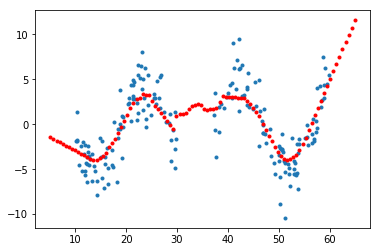

In [8]:
plt.plot(xs,ys,'.')
plt.plot(x_preds,y_preds,'r.')

# Tests
- fit
- _get_window_indices
- _create_weights
- predict

In [18]:
import pytest

# fit - normal
x = np.random.random(size=10).reshape(-1,1)
y = np.random.random(size=10)

model = LoessRegressor(span=0.5).fit(x,y)
assert all(x == model.xs)
assert all(y == model.ys)

# fit - empty frame or inconsistent sizes

with pytest.raises(ValueError):
    x = np.array([]).reshape(-1,1)
    model = LoessRegressor(span=0.5).fit(x,y)
    
    x = np.random.random(size=10)
    y = np.array([])
    model = LoessRegressor(span=0.5).fit(x,y)
    
    x = np.random.random(size=2).reshape(-1,1)
    y = np.random.random(size=9)
    model = LoessRegressor(span=0.5).fit(x,y)
    
# init

# Create x vector such that value is equal to index
xs = np.linspace(start=0, stop=9, num=10).reshape(-1,1)
ys = np.random.random(size=10)

# OK spans
model = LoessRegressor(span=.6).fit(xs,ys)
model = LoessRegressor(span=1).fit(xs,ys)

# Faulty spans
with pytest.raises(ValueError):
    model = LoessRegressor(span=0).fit(xs,ys)
    model._get_window_indices(x[0].reshape(-1,1))
    
    model = LoessRegressor(span=2).fit(x,y)
    model._get_window_indices(x[0].reshape(-1,1))
    
# _get_window_indices

# 100% window
model = LoessRegressor(span=1).fit(xs,ys)
assert all((xs == model._get_window_indices(xs)).reshape(-1,1))


model = LoessRegressor(span=0.1).fit(xs,ys)
assert all(x == model._get_window_indices(x) for x in xs)

model = LoessRegressor(span=0.5).fit(xs.reshape(-1,1),ys)
expected = {0, 1, 2, 3, 4}
result = set(model._get_window_indices(xs[0].reshape(-1,1)))
assert expected == result

expected = {1, 2, 3, 4, 5}
result = set(model._get_window_indices(xs[3].reshape(-1,1)))
assert expected == result

expected = {4, 5, 6, 7, 8}
result = set(model._get_window_indices(xs[6].reshape(-1,1)))
assert expected == result

expected = {5, 6, 7, 8, 9}
result = set(model._get_window_indices(xs[-1].reshape(-1,1)))
assert expected == result

# _create_weights

AssertionError: 

In [ ]:
expected_weighting_methods = ['euclidean', 'equal']
test = None
if test not in expected_weighting_methods:
    raise ValueError(f"Received unexpected weighting method. Choose one from: {expected_weighting_methods}")

In [ ]:
x = np.random.random(size=10)
y = np.random.random(size=9)
LinearRegression().fit(x.reshape(-1,1),y)

In [ ]:
if not x.size > 0:
    print('yes')

True

In [22]:
xs = np.linspace(start=0, stop=9, num=10).reshape(-1, 1)
ys = np.random.random(size=10)

model = LoessRegressor(span=1).fit(xs, ys)

In [34]:
set(xs.flatten()) - set(model._get_window_indices(xs))

set()

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

transformer = Normalizer()
model = LoessRegressor(span=1)

pipeline = Pipeline([('normal', transformer),
                     ('loess', model)
])

xs = np.linspace(start=0, stop=9, num=10).reshape(-1, 1)
ys = np.random.random(size=10)

pipeline.fit(xs, ys).predict(xs)

array([0.10721075, 0.64791878, 0.64791878, 0.64791878, 0.64791878,
       0.64791878, 0.64791878, 0.64791878, 0.64791878, 0.64791878])